# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

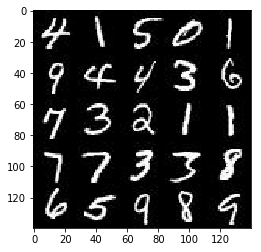

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

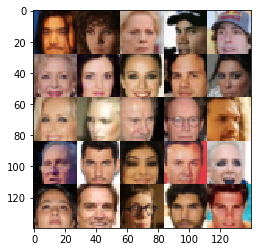

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [25]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/renan/miniconda3/envs/tf_source/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start(

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [85]:
def discriminator(images, reuse=False, n_units=128, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Hidden layer
        h1 = tf.layers.dense(images, n_units, activation=None)
        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        flat = tf.reshape(h1, [-1,int(images.shape[1])*int(images.shape[2])])
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [86]:
def generator(z, out_channel_dim, is_train=True, n_units=128, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """    
    with tf.variable_scope('generator', reuse=not is_train):
        # Hidden layer
        h1 = tf.layers.dense(z, 28*28*out_channel_dim, activation=None)
        
        h1 = tf.reshape(h1, (-1, 28, 28, out_channel_dim))

        # Leaky ReLU
        h1 = tf.maximum(alpha * h1, h1)
        
        # Logits and tanh output
        logits = tf.layers.dense(h1, out_channel_dim, activation=None)
        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [87]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [88]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
       # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [89]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [92]:
def train(epoch_count, batch_size, z_dim, learning_rate_scalar, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate_scalar: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
#     len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels = data_shape
    show_every = 100
    print_every=5
    n_images=25
#     sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    
    inputs_real, inputs_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, learning_rate: learning_rate_scalar})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, learning_rate: learning_rate_scalar})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Step {}/{} Epoch {}/{}...".format(steps, batch_size*epoch_count, epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, data_shape[3], data_image_mode)
                
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step 5/256 Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.6903
Step 10/256 Epoch 1/2... Discriminator Loss: 1.3532... Generator Loss: 0.6898
Step 15/256 Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.6892
Step 20/256 Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.6886
Step 25/256 Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.6880
Step 30/256 Epoch 1/2... Discriminator Loss: 1.3380... Generator Loss: 0.6874
Step 35/256 Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.6868
Step 40/256 Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.6861
Step 45/256 Epoch 1/2... Discriminator Loss: 1.3269... Generator Loss: 0.6855
Step 50/256 Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.6848
Step 55/256 Epoch 1/2... Discriminator Loss: 1.3193... Generator Loss: 0.6842
Step 60/256 Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.6834
Step 65/256 Epoch 1/2... Discriminator Loss: 1.3116... Generator 

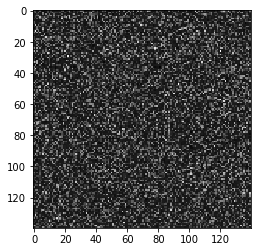

Step 105/256 Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.6792
Step 110/256 Epoch 1/2... Discriminator Loss: 1.2726... Generator Loss: 0.6792
Step 115/256 Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 0.6792
Step 120/256 Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 0.6791
Step 125/256 Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.6791
Step 130/256 Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 0.6792
Step 135/256 Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 0.6794
Step 140/256 Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.6797
Step 145/256 Epoch 1/2... Discriminator Loss: 1.2383... Generator Loss: 0.6797
Step 150/256 Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.6802
Step 155/256 Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 0.6806
Step 160/256 Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.6811
Step 165/256 Epoch 1/2... Discriminator Loss: 1.2192

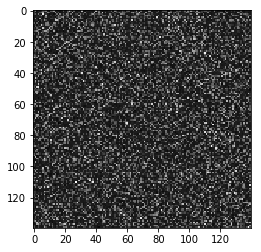

Step 205/256 Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.6906
Step 210/256 Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.6925
Step 215/256 Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 0.6939
Step 220/256 Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.6957
Step 225/256 Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.6971
Step 230/256 Epoch 1/2... Discriminator Loss: 1.1521... Generator Loss: 0.6994
Step 235/256 Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.7012
Step 240/256 Epoch 1/2... Discriminator Loss: 1.1447... Generator Loss: 0.7033
Step 245/256 Epoch 1/2... Discriminator Loss: 1.1382... Generator Loss: 0.7055
Step 250/256 Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.7078
Step 255/256 Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 0.7101
Step 260/256 Epoch 1/2... Discriminator Loss: 1.1236... Generator Loss: 0.7123
Step 265/256 Epoch 1/2... Discriminator Loss: 1.1206

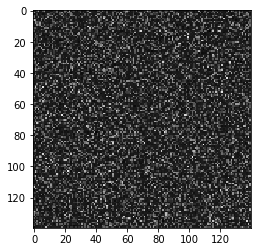

Step 305/256 Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 0.7362
Step 310/256 Epoch 1/2... Discriminator Loss: 1.0763... Generator Loss: 0.7394
Step 315/256 Epoch 1/2... Discriminator Loss: 1.0683... Generator Loss: 0.7427
Step 320/256 Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 0.7454
Step 325/256 Epoch 1/2... Discriminator Loss: 1.0623... Generator Loss: 0.7481
Step 330/256 Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 0.7517
Step 335/256 Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.7546
Step 340/256 Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 0.7579
Step 345/256 Epoch 1/2... Discriminator Loss: 1.0424... Generator Loss: 0.7607
Step 350/256 Epoch 1/2... Discriminator Loss: 1.0344... Generator Loss: 0.7639
Step 355/256 Epoch 1/2... Discriminator Loss: 1.0305... Generator Loss: 0.7676
Step 360/256 Epoch 1/2... Discriminator Loss: 1.0262... Generator Loss: 0.7709
Step 365/256 Epoch 1/2... Discriminator Loss: 1.0244

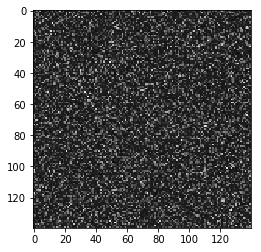

Step 405/256 Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 0.8025
Step 410/256 Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 0.8059
Step 415/256 Epoch 1/2... Discriminator Loss: 0.9771... Generator Loss: 0.8096
Step 420/256 Epoch 1/2... Discriminator Loss: 0.9734... Generator Loss: 0.8132
Step 425/256 Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 0.8162
Step 430/256 Epoch 1/2... Discriminator Loss: 0.9630... Generator Loss: 0.8200
Step 435/256 Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 0.8238
Step 440/256 Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 0.8272
Step 445/256 Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 0.8309
Step 450/256 Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 0.8344
Step 455/256 Epoch 1/2... Discriminator Loss: 0.9385... Generator Loss: 0.8377
Step 460/256 Epoch 1/2... Discriminator Loss: 0.9407... Generator Loss: 0.8409
Step 465/256 Epoch 1/2... Discriminator Loss: 0.9392

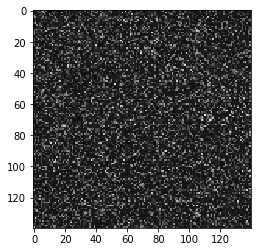

Step 505/256 Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 0.8715
Step 510/256 Epoch 2/2... Discriminator Loss: 0.8989... Generator Loss: 0.8743
Step 515/256 Epoch 2/2... Discriminator Loss: 0.8935... Generator Loss: 0.8774
Step 520/256 Epoch 2/2... Discriminator Loss: 0.8902... Generator Loss: 0.8806
Step 525/256 Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 0.8842
Step 530/256 Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 0.8878
Step 535/256 Epoch 2/2... Discriminator Loss: 0.8769... Generator Loss: 0.8914
Step 540/256 Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 0.8946
Step 545/256 Epoch 2/2... Discriminator Loss: 0.8714... Generator Loss: 0.8977
Step 550/256 Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 0.9012
Step 555/256 Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 0.9041
Step 560/256 Epoch 2/2... Discriminator Loss: 0.8635... Generator Loss: 0.9076
Step 565/256 Epoch 2/2... Discriminator Loss: 0.8592

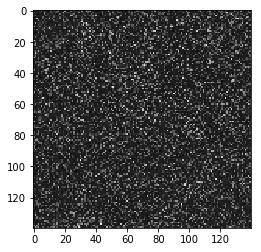

Step 605/256 Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 0.9362
Step 610/256 Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 0.9395
Step 615/256 Epoch 2/2... Discriminator Loss: 0.8180... Generator Loss: 0.9424
Step 620/256 Epoch 2/2... Discriminator Loss: 0.8194... Generator Loss: 0.9457
Step 625/256 Epoch 2/2... Discriminator Loss: 0.8204... Generator Loss: 0.9490
Step 630/256 Epoch 2/2... Discriminator Loss: 0.8120... Generator Loss: 0.9520
Step 635/256 Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 0.9557
Step 640/256 Epoch 2/2... Discriminator Loss: 0.8117... Generator Loss: 0.9592
Step 645/256 Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 0.9613
Step 650/256 Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 0.9646
Step 655/256 Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 0.9680
Step 660/256 Epoch 2/2... Discriminator Loss: 0.7966... Generator Loss: 0.9711
Step 665/256 Epoch 2/2... Discriminator Loss: 0.7953

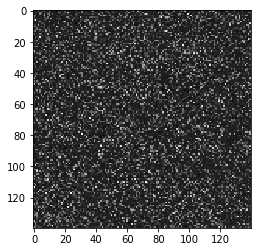

Step 705/256 Epoch 2/2... Discriminator Loss: 0.7691... Generator Loss: 0.9997
Step 710/256 Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 1.0026
Step 715/256 Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 1.0046
Step 720/256 Epoch 2/2... Discriminator Loss: 0.7639... Generator Loss: 1.0086
Step 725/256 Epoch 2/2... Discriminator Loss: 0.7649... Generator Loss: 1.0118
Step 730/256 Epoch 2/2... Discriminator Loss: 0.7683... Generator Loss: 1.0138
Step 735/256 Epoch 2/2... Discriminator Loss: 0.7609... Generator Loss: 1.0161
Step 740/256 Epoch 2/2... Discriminator Loss: 0.7578... Generator Loss: 1.0201
Step 745/256 Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.0234
Step 750/256 Epoch 2/2... Discriminator Loss: 0.7499... Generator Loss: 1.0255
Step 755/256 Epoch 2/2... Discriminator Loss: 0.7519... Generator Loss: 1.0299
Step 760/256 Epoch 2/2... Discriminator Loss: 0.7438... Generator Loss: 1.0327
Step 765/256 Epoch 2/2... Discriminator Loss: 0.7425

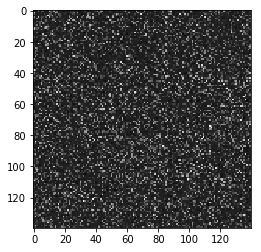

Step 805/256 Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.0592
Step 810/256 Epoch 2/2... Discriminator Loss: 0.7116... Generator Loss: 1.0634
Step 815/256 Epoch 2/2... Discriminator Loss: 0.7186... Generator Loss: 1.0660
Step 820/256 Epoch 2/2... Discriminator Loss: 0.7228... Generator Loss: 1.0681
Step 825/256 Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.0714
Step 830/256 Epoch 2/2... Discriminator Loss: 0.7063... Generator Loss: 1.0739
Step 835/256 Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.0771
Step 840/256 Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.0796
Step 845/256 Epoch 2/2... Discriminator Loss: 0.7032... Generator Loss: 1.0838
Step 850/256 Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 1.0870
Step 855/256 Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 1.0907
Step 860/256 Epoch 2/2... Discriminator Loss: 0.6968... Generator Loss: 1.0940
Step 865/256 Epoch 2/2... Discriminator Loss: 0.7028

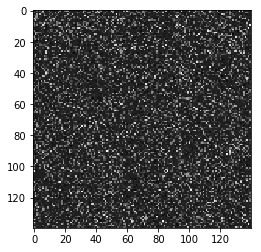

Step 905/256 Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 1.1185
Step 910/256 Epoch 2/2... Discriminator Loss: 0.6855... Generator Loss: 1.1196
Step 915/256 Epoch 2/2... Discriminator Loss: 0.6842... Generator Loss: 1.1228
Step 920/256 Epoch 2/2... Discriminator Loss: 0.6933... Generator Loss: 1.1248
Step 925/256 Epoch 2/2... Discriminator Loss: 0.6816... Generator Loss: 1.1278
Step 930/256 Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.1301
Step 935/256 Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 1.1312


In [93]:
#alpha 0.2
batch_size = 128
z_dim = 100
learning_rate_scalar = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate_scalar, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step 5/256 Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6953
Step 10/256 Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.6934
Step 15/256 Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.6917
Step 20/256 Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.6900
Step 25/256 Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6886
Step 30/256 Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.6874
Step 35/256 Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.6862
Step 40/256 Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6850
Step 45/256 Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.6836
Step 50/256 Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.6825
Step 55/256 Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6812
Step 60/256 Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6800
Step 65/256 Epoch 1/1... Discriminator Loss: 1.3681... Generator 

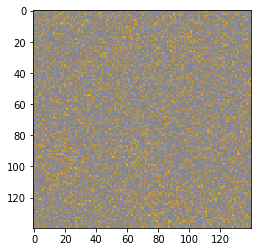

Step 105/256 Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6696
Step 110/256 Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6683
Step 115/256 Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6674
Step 120/256 Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.6666
Step 125/256 Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6659
Step 130/256 Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6650
Step 135/256 Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6644
Step 140/256 Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6637
Step 145/256 Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.6630
Step 150/256 Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6629
Step 155/256 Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6625
Step 160/256 Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 0.6619
Step 165/256 Epoch 1/1... Discriminator Loss: 1.3414

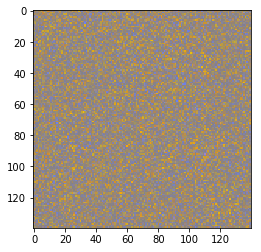

Step 205/256 Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6613
Step 210/256 Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.6615
Step 215/256 Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.6618
Step 220/256 Epoch 1/1... Discriminator Loss: 1.3218... Generator Loss: 0.6618
Step 225/256 Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.6623
Step 230/256 Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.6628
Step 235/256 Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.6631
Step 240/256 Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.6641
Step 245/256 Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.6646
Step 250/256 Epoch 1/1... Discriminator Loss: 1.3074... Generator Loss: 0.6654
Step 255/256 Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.6659
Step 260/256 Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6667
Step 265/256 Epoch 1/1... Discriminator Loss: 1.2997

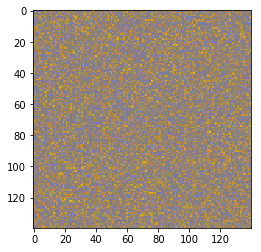

Step 305/256 Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6768
Step 310/256 Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6786
Step 315/256 Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6808
Step 320/256 Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6821
Step 325/256 Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6837
Step 330/256 Epoch 1/1... Discriminator Loss: 1.2559... Generator Loss: 0.6856
Step 335/256 Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.6878
Step 340/256 Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6893
Step 345/256 Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.6919
Step 350/256 Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.6938
Step 355/256 Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.6960
Step 360/256 Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.6983
Step 365/256 Epoch 1/1... Discriminator Loss: 1.2320

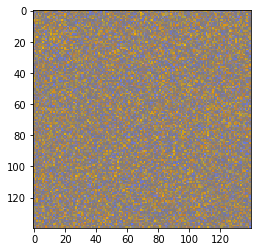

Step 405/256 Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.7202
Step 410/256 Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.7230
Step 415/256 Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.7253
Step 420/256 Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7284
Step 425/256 Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.7309
Step 430/256 Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 0.7340
Step 435/256 Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.7376
Step 440/256 Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.7401
Step 445/256 Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.7425
Step 450/256 Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.7453
Step 455/256 Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.7478
Step 460/256 Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.7500
Step 465/256 Epoch 1/1... Discriminator Loss: 1.1530

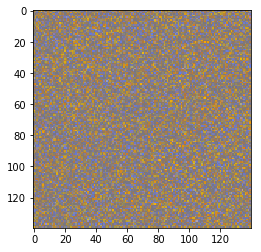

Step 505/256 Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 0.7718
Step 510/256 Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.7739
Step 515/256 Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.7752
Step 520/256 Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 0.7776
Step 525/256 Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 0.7801
Step 530/256 Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.7826
Step 535/256 Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.7847
Step 540/256 Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 0.7857
Step 545/256 Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.7884
Step 550/256 Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 0.7909
Step 555/256 Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7923
Step 560/256 Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.7947
Step 565/256 Epoch 1/1... Discriminator Loss: 1.0864

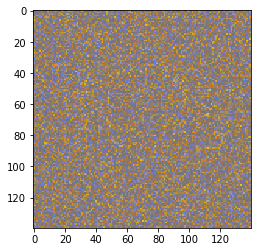

Step 605/256 Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.8098
Step 610/256 Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 0.8105
Step 615/256 Epoch 1/1... Discriminator Loss: 1.0558... Generator Loss: 0.8113
Step 620/256 Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 0.8142
Step 625/256 Epoch 1/1... Discriminator Loss: 1.0720... Generator Loss: 0.8152
Step 630/256 Epoch 1/1... Discriminator Loss: 1.0629... Generator Loss: 0.8161
Step 635/256 Epoch 1/1... Discriminator Loss: 1.0538... Generator Loss: 0.8175
Step 640/256 Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.8194
Step 645/256 Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.8212
Step 650/256 Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 0.8216
Step 655/256 Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.8231
Step 660/256 Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 0.8234
Step 665/256 Epoch 1/1... Discriminator Loss: 1.0672

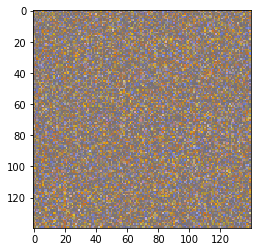

Step 705/256 Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.8292
Step 710/256 Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 0.8292
Step 715/256 Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.8299
Step 720/256 Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.8316
Step 725/256 Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 0.8296
Step 730/256 Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 0.8316
Step 735/256 Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 0.8319
Step 740/256 Epoch 1/1... Discriminator Loss: 1.0760... Generator Loss: 0.8331
Step 745/256 Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 0.8334
Step 750/256 Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.8344
Step 755/256 Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 0.8347
Step 760/256 Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 0.8342
Step 765/256 Epoch 1/1... Discriminator Loss: 1.0766

In [95]:
batch_size = 256
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.